# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who voted whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
!pip install nltk

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 64.7 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [ ]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')
#filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [ ]:
display['COUNT(*)'].sum()

np.int64(393063)

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator>HelpfulnessDenominator
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


,count
Score,
1,7976
0,1588


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)  # http\S+- starts with http and have one or more characters otherthan space
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [ ]:
!pip install bs4

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'html.parser')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [ ]:
23 | cf67j | 67j |gh67

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip() #continuous non-space sequence that contains at least one digit.
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)#any sequence of one or more characters that are NOT letters or digits
print(sent_1500)

We have used the Victor fly bait for seasons Can t beat it Great product 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

- remove http
-removexml/html
-remove alpha numeric or numeric
-emove special char
-removestopword
-decontraction

In [ ]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:02<00:00, 3303.00it/s]


In [ ]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

In [ ]:
preprocessed_reviews

['used victor fly bait seasons ca not beat great product',
 'product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'good flavor unique teas tried tea effective cleansing one system not harsh regular laxative consumed daily needed',
 'used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using try little sips see result morning earlier follow lots water',
 'new product need careful dosage strong batches stronger others',
 'using food months find excellent fact two dogs coton de tule

#  Encoding


colour: blue | green | blue

Why are word embeddings needed?

Let us consider the two sentences – “You can scale your business.” and “You can grow your business.”. These two sentences have the same meaning. If we consider a vocabulary considering these two sentences, it will constitute of these words: {You, can, scale, grow, your, business}.

A one-hot encoding of these words would create a vector of length 6. The encodings for each of the words would look like this:

You: [1,0,0,0,0,0], Can: [0,1,0,0,0,0], Scale: [0,0,1,0,0,0], Grow: [0,0,0,1,0,0],

Your: [0,0,0,0,1,0], Business: [0,0,0,0,0,1]

In a 6-dimensional space, each word would occupy one of the dimensions, meaning that none of these words has any similarity with each other – irrespective of their literal meanings.

Word2Vec, a word embedding methodology, solves this issue and enables similar words to have similar dimensions and, consequently, helps bring context.

#https://www.analyticsvidhya.com/blog/2021/07/word2vec-for-word-embeddings-a-beginners-guide/

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(["i love machine learning machine", "i love deep learning"])
print(count_vect.get_feature_names_out())


['deep' 'learning' 'love' 'machine']


In [ ]:
final_s = count_vect.transform(["i love machine learning machine", "i love deep learning"])
final_s

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (2, 4)>

In [ ]:
print(final_s.toarray())

[[0 1 1 2]
 [1 1 1 0]]


In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa' 'aaaa' 'aahhhs' 'ab' 'aback' 'abandon' 'abates' 'abberline' 'abbott'
 'abby']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 18244)
the number of unique words  18244


## [4.2] Bi-Grams and n-Grams.

['deep' 'deep learning' 'i' 'i love' 'learning' 'love' 'love deep' 'love machine' 'machine' 'machine learning']

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF
how many times in the review and and in how many revies

here  tf in doc2 for learning and deep is wrong ,its 1/5-->0.2

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability' 'able' 'able buy' 'able eat' 'able find' 'able get'
 'able order' 'able use' 'absolute' 'absolute best']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9564, 5765)
the number of unique words including both unigrams and bigrams  5765


## [4.4] Word2Vec

In [ ]:
river bank - bank balance

In [ ]:
from gensim.models import Word2Vec

# Sample corpus (list of sentences, each sentence is a list of words)
sentences = [
    ["I", "love", "machine", "learning"],
    ["Deep", "learning", "is", "fun"],
    ["I", "enjoy", "learning", "new", "things"]
]

# Train Word2Vec model
# vector_size = dimensions of the word vectors
# window = context window size
# min_count = ignore words appearing less than this
model = Word2Vec(sentences, vector_size=10, window=3, min_count=1, sg=0)  # sg=0 =>CBOW (Continuous Bag of Words)Predicts a target word from its surrounding context words.

# Get vector for a word
vector = model.wv['learning']
print("Vector for 'learning':")
print(vector)

# Find similar words
similar = model.wv.most_similar('learning', topn=3)
print("\nTop 3 words similar to 'learning':")
print(similar)


Vector for 'learning':
[-0.00536227  0.00236431  0.0510335   0.09009273 -0.0930295  -0.07116809
  0.06458873  0.08972988 -0.05015428 -0.03763372]

Top 3 words similar to 'learning':
[('I', 0.5436005592346191), ('machine', 0.3792896568775177), ('things', 0.3004249036312103)]


In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.8933413624763489), ('good', 0.8659423589706421), ('quick', 0.7787799835205078), ('wonderful', 0.7621606588363647), ('overall', 0.7421642541885376), ('makes', 0.7401448488235474), ('easy', 0.733809769153595), ('super', 0.7256690263748169), ('looking', 0.7158928513526917), ('decent', 0.712273895740509)]
[('absolute', 0.9774490594863892), ('hands', 0.975250244140625), ('stephen', 0.9725447297096252), ('varieties', 0.9708076119422913), ('disappointing', 0.9702789783477783), ('blends', 0.96975177526474), ('compares', 0.9692646861076355), ('assured', 0.9670110940933228), ('cafe', 0.9663616418838501), ('columbian', 0.9660125374794006)]


In [ ]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5652
sample words  ['not', 'like', 'good', 'great', 'taste', 'coffee', 'one', 'would', 'product', 'flavor', 'love', 'no', 'tea', 'food', 'really', 'get', 'much', 'use', 'best', 'time', 'amazon', 'also', 'tried', 'little', 'make', 'buy', 'price', 'find', 'well', 'better', 'try', 'even', 'cup', 'chips', 'bag', 'chocolate', 'sugar', 'water', 'eat', 'first', 'hot', 'could', 'drink', 'made', 'found', 'mix', 'used', 'bought', 'free', 'sweet']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 9564/9564 [00:18<00:00, 521.97it/s] 

9564
100


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 9564/9564 [03:19<00:00, 47.88it/s]


tfidf_sent_vectors - train test split - ml algoriths | accuracy,p,r,confusion max

In [ ]:
#logistic

In [ ]:
type(final)

pandas.core.frame.DataFrame

In [ ]:
preprocessed_reviews

['used victor fly bait seasons ca not beat great product',
 'product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'good flavor unique teas tried tea effective cleansing one system not harsh regular laxative consumed daily needed',
 'used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using try little sips see result morning earlier follow lots water',
 'new product need careful dosage strong batches stronger others',
 'using food months find excellent fact two dogs coton de tule

In [ ]:
x=tfidf_sent_vectors
y=final['Score']

# USING LOGISTIC REGRESSION


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


In [ ]:
logit = LogisticRegression(fit_intercept=True, penalty='l1',solver='liblinear')
logit.fit(X_train, y_train)


LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,6,60,66
1,19,329,348
All,25,389,414


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

Accuracy is 0.85
Precision is 0.85
Recall is 0.99


In [ ]:
print("Classification Report:")
print(classification_report(y_test, logit_pred))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, logit_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.20      0.32       338
           1       0.85      0.99      0.91      1575

    accuracy                           0.85      1913
   macro avg       0.81      0.60      0.62      1913
weighted avg       0.84      0.85      0.81      1913

 Confusion Matrix:
[[  69  269]
 [  21 1554]]


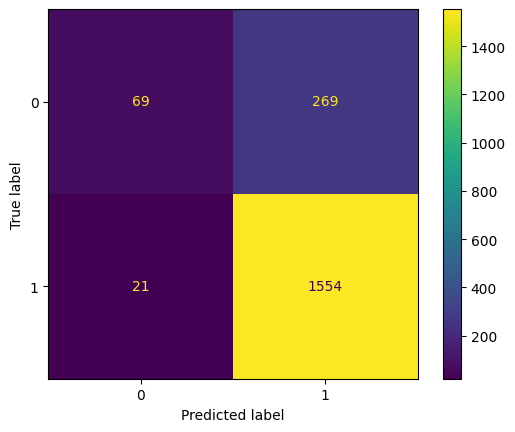

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(logit, X_test, y_test)
plt.show()




*  Model performs very well for class 1 (high recall and precision).




*   Model performs poorly for class 0 — it fails to identify many of them (low recall = 0.20).

This happens due to class imbalance: there are many more 1s (1575) than 0s (338).

So the model is biased toward predicting 1.

# USING SUPPORT VECTOR MACHINE

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


In [ ]:
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))

Accuracy is 0.85
Precision is 0.85
Recall is 0.99


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.18      0.30       338
           1       0.85      0.99      0.91      1575

    accuracy                           0.85      1913
   macro avg       0.83      0.59      0.61      1913
weighted avg       0.84      0.85      0.81      1913

 Confusion Matrix:
[[  62  276]
 [  15 1560]]


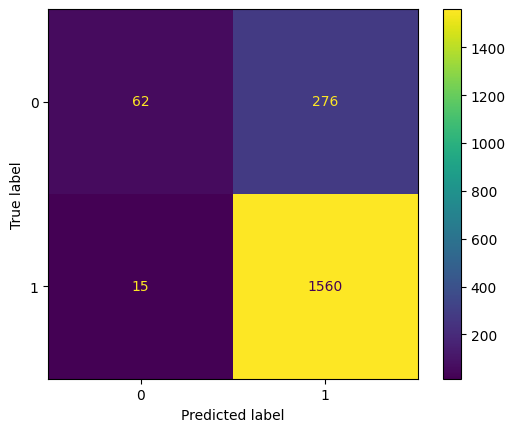

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
plt.show()

Overall Accuracy = 0.85 — decent overall.

Class imbalance issue: Model predicts class 1 far more accurately than class 0.

Class 0 recall is low (0.18) — many 0s are misclassified as 1.

Class 1 recall is excellent (0.99) — model identifies positives very well.



TRYING TO BALANCE

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)
svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)


print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))



Accuracy: 0.7491


In [ ]:
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))

Precision is 0.95
Recall is 0.73


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.82      0.52       318
           1       0.95      0.73      0.83      1595

    accuracy                           0.75      1913
   macro avg       0.67      0.78      0.68      1913
weighted avg       0.86      0.75      0.78      1913

 Confusion Matrix:
[[ 261   57]
 [ 423 1172]]


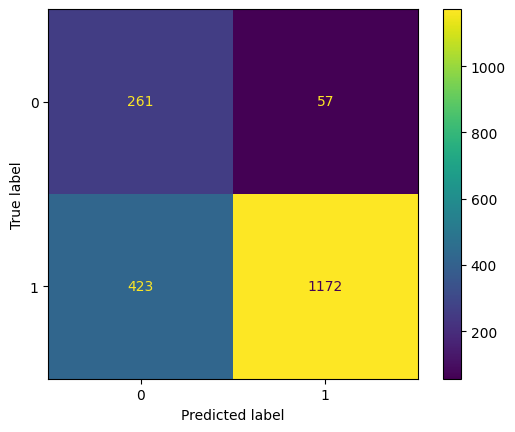

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
plt.show()

Balanced SVM successfully improved  class 0 detection

Recall jumped from 0.18 → 0.82

Accuracy dropped slightly (0.85 → 0.75)


 class 0 recall ↑

 class 1 recall ↓ slightly

Overall model fairness improves.

# USING DECISION TREE

In [ ]:

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


y_pred = dt_model.predict(X_test)


print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7548

 Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.30      0.30       338
           1       0.85      0.85      0.85      1575

    accuracy                           0.75      1913
   macro avg       0.58      0.57      0.58      1913
weighted avg       0.75      0.75      0.75      1913


 Confusion Matrix:
[[ 100  238]
 [ 231 1344]]


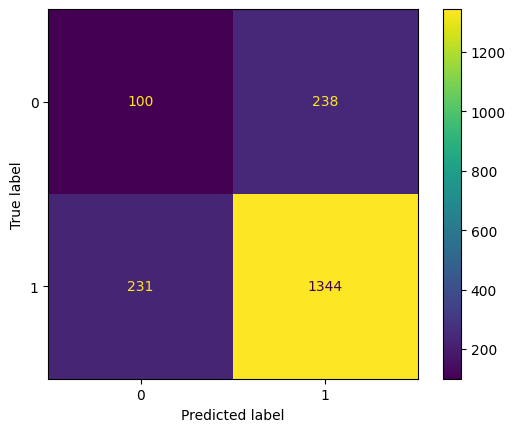

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test)
plt.show()

Class 1
 The model performs very well for positive reviews — both precision and recall are high (0.85).


Class 0
The model performs poorly for negative reviews.

Precision (0.30): Only 30% of reviews predicted as negative were actually negative.

Recall (0.30): It only caught 30% of the actual negative reviews.


Overall Logistic Regression has high accuracy

# Preprocessing Summary

In [ ]:
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)
sent_3900 = final['Summary'].values[3900]
print(sent_3900)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)

Flies Begone
Great taste!
Excellent Tortilla chips
Mediocre
Pretty cool, but not life changing.


In [ ]:

print(final['Summary'].head(10))


2547                            Flies Begone
2546                           thirty bucks?
1145          WOW Make your own 'slickers' !
1146                           Great Product
8695                 Good, effective product
8696    The Best Cleansing Tea I've Ever Had
8694           Best herbal tea for digestion
2941             Premium Quality Dog Food!!!
2942                             Good stuff!
1071                           Cats love it!
Name: Summary, dtype: object


In [ ]:
import nltk
nltk.download('stopwords')
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords


stop_words = set(stopwords.words('english'))

def decontracted(phrase):
    """Expand common contractions like don't -> do not"""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

preprocessed_Summary = []

for sentence in tqdm(final['Summary'].astype(str).values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'html.parser').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub(r'\S*\d\S*', '', sentence).strip()
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    sentence = ' '.join(
        word.lower() for word in sentence.split()
        if word.lower() not in stop_words
    )
    preprocessed_Summary.append(sentence.strip())


final['Cleaned_Summary'] = preprocessed_Summary


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 9564/9564 [00:02<00:00, 3705.45it/s]


In [ ]:
preprocessed_Summary

['flies begone',
 'thirty bucks',
 'wow make islickers',
 'great product',
 'good effective product',
 'best cleansing tea ever',
 'best herbal tea digestion',
 'premium quality dog food',
 'good stuff',
 'cats love',
 'family favorite looks like steak',
 'great food',
 '',
 'cats love food',
 'stuff bad',
 'four cats love',
 'best',
 'great food',
 'great food cats',
 'needs improved',
 'awesome food',
 'cat favorite',
 'great product',
 'finicky eater favorite food',
 'mmmmmmmeeeeeeeeeeooooooooooowwwwwww',
 'one great big huge highfivefrom cat',
 'great dogs',
 'unless want pick dog poop floori recommend',
 'great dog food',
 'false advertising terrible dog food',
 'dog loves love',
 'dog eat poop like crazy',
 'wow',
 'love tea',
 'delicious tea',
 'nice big pieces big almond flavor',
 'summer treat fat free guilt free',
 'little flavor',
 'buy product unless looking shredded coconut',
 'awesome mints even without allergies',
 'delicious complementary flavors',
 'gluten dairy corn s

In [ ]:
i=0
list_of_sentence=[]
for sentence in preprocessed_Summary:
    list_of_sentence.append(sentence.split())

In [ ]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,vector_size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.9990493655204773), ('like', 0.9989336729049683), ('chocolate', 0.9988700151443481), ('best', 0.9987903833389282), ('low', 0.998736560344696), ('flavor', 0.9987181425094604), ('one', 0.9986947178840637), ('taste', 0.99863201379776), ('mix', 0.9986075758934021), ('better', 0.9985869526863098)]
[('love', 0.9901916980743408), ('best', 0.9900257587432861), ('favorite', 0.9895089864730835), ('healthy', 0.9894608855247498), ('food', 0.9894400835037231), ('sweet', 0.9893698692321777), ('amazon', 0.9893561601638794), ('k', 0.9893215298652649), ('taste', 0.9892690181732178), ('flavor', 0.9892533421516418)]


In [ ]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  863
sample words  ['great', 'good', 'best', 'love', 'coffee', 'product', 'delicious', 'taste', 'tea', 'excellent', 'flavor', 'food', 'yummy', 'ever', 'tasty', 'dog', 'like', 'hot', 'price', 'favorite', 'chips', 'chocolate', 'snack', 'stuff', 'awesome', 'healthy', 'better', 'perfect', 'loves', 'free', 'one', 'really', 'wonderful', 'sweet', 'mix', 'yum', 'nice', 'quality', 'cocoa', 'tastes', 'tasting', 'easy', 'buy', 'cat', 'bad', 'gluten', 'organic', 'amazing', 'dogs', 'treat']


In [ ]:
sent_vectors = [];
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(100)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 9564/9564 [00:03<00:00, 2967.59it/s]

9564
100


In [ ]:
x1=sent_vectors
y1=final['Score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x1,y1, test_size=0.2, random_state=42)

Accuracy: 0.8201777313120753


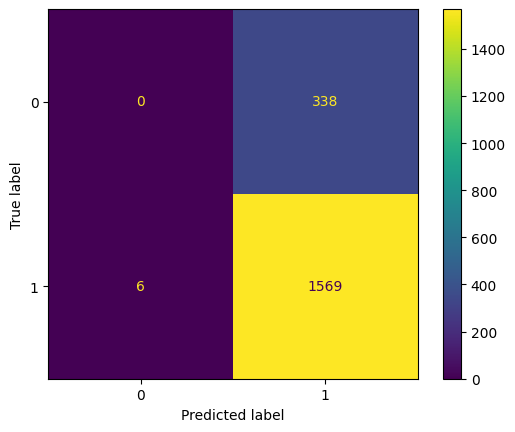

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred1 =model_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred1)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred1)))

Precision is 0.82
Recall is 1.00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x1,y1, test_size=0.2, random_state=42)

Accuracy: 0.8233141662310507


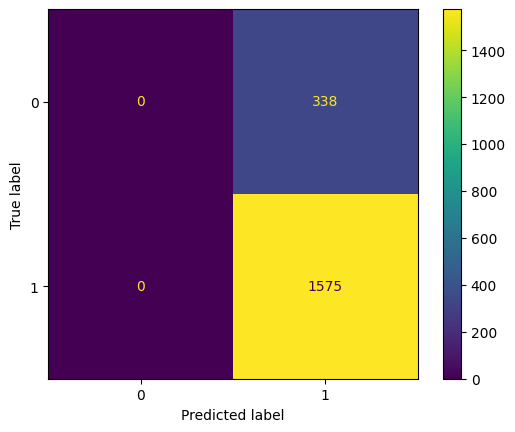

In [ ]:
from sklearn.svm import LinearSVC
model_svm1 = LinearSVC(C=1.0, random_state=42)
model_svm1.fit(X_train, y_train)
y_pred_svm1 = model_svm1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm1))
ConfusionMatrixDisplay.from_estimator(model_svm1, X_test, y_test)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred_svm1)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred_svm1)))

Precision is 0.82
Recall is 1.00


In [ ]:
model = TfidfVectorizer()
model.fit(preprocessed_Summary)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [ ]:
tfidf_feat = model.get_feature_names_out()

tfidf_sent_vectors = [];
row=0;
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(100)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 9564/9564 [00:02<00:00, 3572.74it/s]


In [ ]:
x2=tfidf_sent_vectors
y2=final['Score']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(x2,y2,test_size=0.2,random_state=42)

Accuracy: 0.7956089911134344


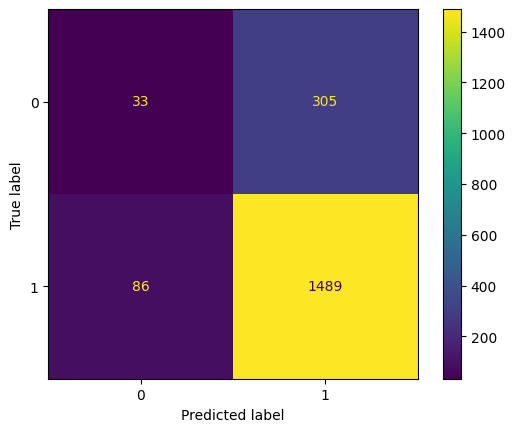

In [ ]:
from sklearn.linear_model import LogisticRegression
model_lr2 = LogisticRegression()
model_lr2.fit(X_train, y_train)
y_pred2 =model_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred2)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred2)))

Precision is 0.83
Recall is 0.95


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(x2,y2,test_size=0.2,random_state=42)

Accuracy: 0.8233141662310507


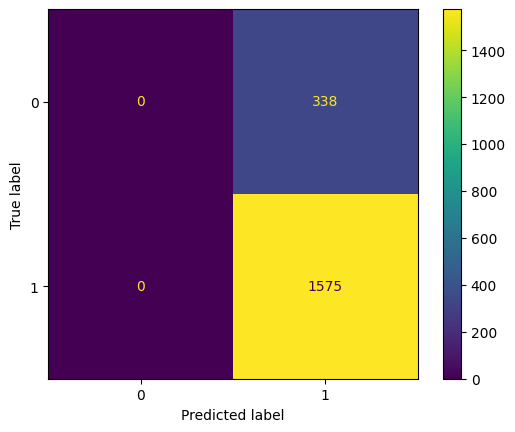

In [ ]:
from sklearn.svm import LinearSVC
model_svm2 = LinearSVC(C=1.0, random_state=42)
model_svm2.fit(X_train, y_train)
y_pred_svm2 = model_svm2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm2))
ConfusionMatrixDisplay.from_estimator(model_svm1, X_test, y_test)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred_svm2)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred_svm2)))

Precision is 0.82
Recall is 1.00


Overall Support Vector Machine has high accuracy